In [201]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.models import resnet18, resnet50, densenet121, mobilenet_v2

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

import json
import os
import os.path as path

In [202]:
# plt.rcParams["font.family"] = "Malgun Gothic" # window
plt.rcParams["font.family"] = "AppleGothic" # Apple

In [10]:
class SkinClassfierModel(nn.Module):
    def __init__(self):
        super(SkinClassfierModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(64, 32, 3, 1)
        self.dropout2 = nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(32, 16, 3, 1)
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc1 = nn.Linear(16 * 62 * 62, 6)
        self.res = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout3(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.res(x)
        return x

In [11]:
# class ImageDataset(Dataset):
#     def __init__(self, json_dir, img_dir, transform=None):
#         self.img_dir = img_dir
#         self.json_dir = json_dir
#         self.transform = transform
        
#         self.img_files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.png'))])
    
#     def __len__(self):
#         return len(self.img_files)
    
#     def __getitem__(self, idx):
#         img_name = self.img_files[idx]
#         img_path = os.path.join(self.img_dir, img_name)
#         json_path = os.path.join(self.json_dir, os.path.splitext(img_name)[0] + ".json")
#         image = Image.open(img_path).convert("RGB")
        
#         with open(json_path, 'r', encoding='utf-8') as f:
#             annot = json.load(f)
        
#         mask = np.zeros((h, w), dtype=np.uint8)

In [211]:
transform_train = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.RandomVerticalFlip(),
  transforms.RandomRotation(20),
  transforms.ColorJitter(
    brightness=0.2,
    contrast=0.2,
    saturation=0.2,
    hue=0.1
  ),
  transforms.ToTensor()
])

transform_val = transforms.Compose([
  transforms.ToTensor(),
])

In [212]:
dataset_train = datasets.ImageFolder(root=path.join("dataset", "training", "resource"), transform=transform_train)
train_dataloader = DataLoader(dataset_train, 8, shuffle=True, num_workers=0)
print(dataset_train.classes)
print(dataset_train.class_to_idx)
idx_to_class = {v:k for k , v in dataset_train.class_to_idx.items()}

dataset_valid = datasets.ImageFolder(root=path.join("dataset", "validation", "resource"), transform=transform_val)
validation_dataloader = DataLoader(dataset_valid,shuffle=False)

['건선', '아토피', '여드름', '정상', '주사', '지루']
{'건선': 0, '아토피': 1, '여드름': 2, '정상': 3, '주사': 4, '지루': 5}


In [ ]:
plt.subplot()

# 모델 선정

In [ ]:
# Resnet

# model = SkinClassfierModel()
model = resnet50() # ImageNet 1000 => 6
# 마지막 fc 레이어 교체
num_ftrs = model.fc.in_features  # 2048
model.fc = nn.Linear(num_ftrs, 6)
model.to("mps")
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [167]:
# Densenet

# model = SkinClassfierModel()
model = densenet121() # ImageNet 1000 => 6
# 마지막 fc 레이어 교체
# model.fc = nn.Linear(num_ftrs, 6)
num_ftrs = model.classifier.in_features  # 2048
model.classifier = nn.Linear(num_ftrs, 6)
model.to("mps")
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [204]:
# Densenet

# model = SkinClassfierModel()
model = mobilenet_v2() # ImageNet 1000 => 6
# 마지막 fc 레이어 교체
# model.fc = nn.Linear(num_ftrs, 6)
print(model.features)

num_ftrs = model.classifier[1].in_features  # 2048
model.classifier[1] = nn.Linear(num_ftrs, 6)
model.to("mps")

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [205]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0001)

In [206]:
epoch_train_loss = []
epoch_train_accuracy = []

epoch_valid_loss = []
epoch_valid_accuracy = []

In [219]:
import torch

def train_one_epoch(epoch_index, model, train_dataloader, optimizer, loss_fn, device):
    running_loss = 0.
    last_loss = 0.
    running_correct = 0
    total_samples = 0

    model.train()

    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

        if i % 100 == 0 and i != 0:
            last_loss = running_loss / 100
            last_acc = running_correct / total_samples * 100
            print(f'[Train] Batch {i+1}/{len(train_dataloader)} | Loss: {last_loss:.4f} | Acc: {last_acc:.2f}%')
            running_loss = 0.
            running_correct = 0
            total_samples = 0

    epoch_loss = last_loss
    epoch_acc = last_acc
    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    model.eval()
    
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            batch_correct = (predicted == labels).sum().item()
            batch_total = labels.size(0)
            batch_acc = 100 * batch_correct / batch_total

            correct += batch_correct
            total += batch_total

            print(f'[Val] Batch {batch_idx+1}/{len(val_loader)} | Loss: {loss.item():.4f} | Acc: {batch_acc:.2f}%')

    avg_loss = total_loss / len(val_loader)
    accuracy = 100 * correct / total
    print(f'[Val] Avg Loss: {avg_loss:.4f}, Avg Acc: {accuracy:.2f}%')

    return avg_loss, accuracy


# ========== 학습 루프 예시 ==========
best_val_acc = 0.0
model_path = "best_model.pth"
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

for epoch in range(1):
    print(f"\n===== Epoch {epoch+1}/{1} =====")
    train_loss, train_acc = train_one_epoch(epoch, model, train_dataloader, optimizer, loss_fn, device)
    epoch_train_loss.append(train_loss)
    epoch_train_accuracy.append(train_acc)
    val_loss, val_acc = validate(model, validation_dataloader, loss_fn, device)
    epoch_valid_loss.append(val_loss)
    epoch_valid_accuracy.append(val_acc)

    # Best model 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_path)
        print(f"💾 Best model saved with val_acc: {best_val_acc:.2f}%")



===== Epoch 1/1 =====
[Train] Batch 101/600 | Loss: 0.7586 | Acc: 72.40%
[Train] Batch 201/600 | Loss: 0.8160 | Acc: 70.75%
[Train] Batch 301/600 | Loss: 0.7321 | Acc: 71.00%
[Train] Batch 401/600 | Loss: 0.8120 | Acc: 71.12%
[Train] Batch 501/600 | Loss: 0.7272 | Acc: 73.25%
[Val] Batch 1/600 | Loss: 2.5010 | Acc: 0.00%
[Val] Batch 2/600 | Loss: 0.2432 | Acc: 100.00%
[Val] Batch 3/600 | Loss: 0.1386 | Acc: 100.00%
[Val] Batch 4/600 | Loss: 0.2922 | Acc: 100.00%
[Val] Batch 5/600 | Loss: 0.6699 | Acc: 100.00%
[Val] Batch 6/600 | Loss: 0.1020 | Acc: 100.00%
[Val] Batch 7/600 | Loss: 0.0282 | Acc: 100.00%
[Val] Batch 8/600 | Loss: 0.3214 | Acc: 100.00%
[Val] Batch 9/600 | Loss: 0.7808 | Acc: 100.00%
[Val] Batch 10/600 | Loss: 0.6595 | Acc: 100.00%
[Val] Batch 11/600 | Loss: 0.1406 | Acc: 100.00%
[Val] Batch 12/600 | Loss: 1.2892 | Acc: 0.00%
[Val] Batch 13/600 | Loss: 2.4607 | Acc: 0.00%
[Val] Batch 14/600 | Loss: 0.8445 | Acc: 0.00%
[Val] Batch 15/600 | Loss: 1.2662 | Acc: 0.00%
[Val] 

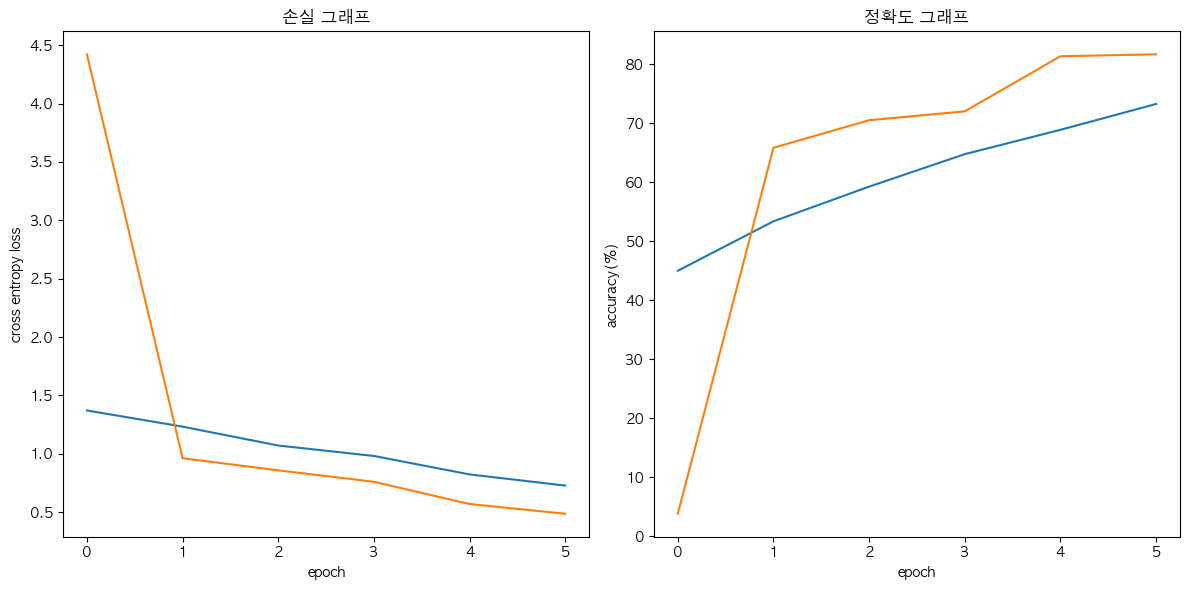

In [237]:
plt.figure(figsize=(12, 6))

plt.subplot(1,2, 1)
plt.plot(epoch_train_loss)
plt.plot(epoch_valid_loss)
plt.xlabel("epoch")
plt.ylabel("cross entropy loss")
plt.title("손실 그래프")

plt.subplot(1,2, 2)
plt.plot(epoch_train_accuracy)
plt.plot(epoch_valid_accuracy)
plt.xlabel("epoch")
plt.ylabel("accuracy(%)")
plt.title("정확도 그래프")


plt.tight_layout()
plt.show()

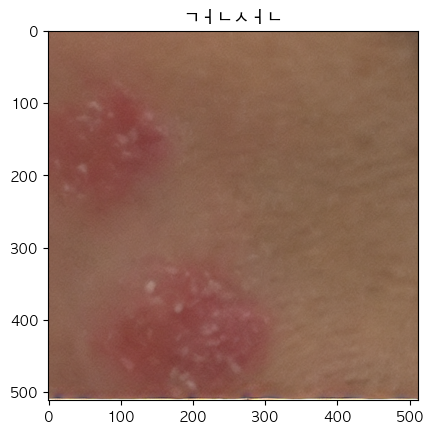


아토피


In [261]:
# 모델 저장 후 불러오기
# torch.save(model.state_dict(), 'mobilenet_model.pth')

model.load_state_dict(torch.load('mobilenet_model.pth',map_location='mps'))
model.eval()
images, labels = next(iter(validation_dataloader))
to_pil = transforms.ToPILImage()
img_pil = to_pil(images.squeeze(0))
plt.imshow(img_pil)
plt.title(f"{idx_to_class[labels.item()]}")
plt.show()

print()

with torch.no_grad():
  model.eval()
  img = torch.Tensor(images[0]).unsqueeze_(0).to('mps')
  pred = model(img)
  print(idx_to_class[pred.argmax().item()])
  

In [ ]:
def validate(model, val_loader, criterion, device):
    model.eval()
    
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # 배치별 Accuracy 계산
            _, predicted = torch.max(outputs, 1)
            batch_correct = (predicted == labels).sum().item()
            
            batch_total = labels.size(0)
            batch_acc = 100 * batch_correct / batch_total

            # 누적 정확도 업데이트
            correct += batch_correct
            total += batch_total

    avg_loss = total_loss / len(val_loader)
    accuracy = 100 * correct / total
    print(f"Validation Avg Loss: {avg_loss:.4f}, Avg Accuracy: {accuracy:.2f}%")

    return avg_loss, accuracy


In [ ]:
validate(model, validation_dataloader, torch.nn.CrossEntropyLoss(), 'mps')

[Val] Batch 1/600 | Loss: 2.5790 | Acc: 0.00%
[Val] Batch 2/600 | Loss: 0.8424 | Acc: 100.00%
[Val] Batch 3/600 | Loss: 0.7803 | Acc: 100.00%
[Val] Batch 4/600 | Loss: 0.6374 | Acc: 100.00%
[Val] Batch 5/600 | Loss: 0.5682 | Acc: 100.00%
[Val] Batch 6/600 | Loss: 0.6297 | Acc: 100.00%
[Val] Batch 7/600 | Loss: 0.3580 | Acc: 100.00%
[Val] Batch 8/600 | Loss: 1.3417 | Acc: 0.00%
[Val] Batch 9/600 | Loss: 1.0115 | Acc: 0.00%
[Val] Batch 10/600 | Loss: 0.9577 | Acc: 0.00%
[Val] Batch 11/600 | Loss: 0.7395 | Acc: 100.00%
[Val] Batch 12/600 | Loss: 0.7466 | Acc: 100.00%
[Val] Batch 13/600 | Loss: 1.0851 | Acc: 100.00%
[Val] Batch 14/600 | Loss: 0.7503 | Acc: 100.00%
[Val] Batch 15/600 | Loss: 0.8616 | Acc: 100.00%
[Val] Batch 16/600 | Loss: 0.6474 | Acc: 100.00%
[Val] Batch 17/600 | Loss: 1.0728 | Acc: 100.00%
[Val] Batch 18/600 | Loss: 0.9659 | Acc: 100.00%
[Val] Batch 19/600 | Loss: 1.3462 | Acc: 0.00%
[Val] Batch 20/600 | Loss: 0.4122 | Acc: 100.00%
[Val] Batch 21/600 | Loss: 0.4202 | Acc

(3.0561976566910745, 19.833333333333332)

In [174]:
val_loss, val_acc = validate(model, validation_dataloader, loss_fn, device)

# Best model 저장
print(f"💾 Best model saved with val_acc: {best_val_acc:.2f}%")

Validation Avg Loss: 5.9788, Avg Accuracy: 4.00%
💾 Best model saved with val_acc: 4.00%
